In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import os

import numpy as np
import matplotlib.pyplot as plt

from NormalizingFlows.src.train import train_backward
from NormalizingFlows.src.scores import log_likelihood
from NormalizingFlows.src.utils import update_device, load_best_model, load_checkpoint_model

from NormalizingFlows.src.flows import *
from NormalizingFlows.src.data.density.power import Power

In [3]:
def set_visible_devices(*devices: int) -> None:
    '''Utility to set visible Cuda devices.

    Parameters
    ----------
    devices : List[int]
        Index of cuda devices to make available for use.
    '''
    assert all([d >= 0 for d in devices]), f"Not all devices are CUDA devices!"
    os.environ['CUDA_VISIBLE_DEVICES'] = ",".join([str(i) for i in devices])
    

def set_devices(*devices: int):
    '''Utility to set Cuda device(s).

    Parameters
    ----------
    devices : List[int]
        Index of cuda devices to make available for use.

    Returns
    -------
    torch.device or List[torch.device] of currently available CUDA devices.
    '''
    assert len(devices) > 0, f'Device list is empty, no devices set.'
    if len(devices) == 1:
        if devices[0] >= 0:
            set_visible_devices(devices[0])
            return torch.device(0)
        else:
            return torch.device('cpu')

    else:
        set_visible_devices(*devices)
        return [torch.device(i) for i in range(len(devices))]

In [4]:
device = set_devices(6) #torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device_cpu = torch.device("cpu")

In [5]:
dataset = Power()
dim_input = dataset.dim_input
num_trans = 10 #Must be even

dim_hidden = [512,512]
flows = {}
flow_forward = False


epochs = 8
batch_size = 128
num_exp = 3

In [6]:
f_a = lambda x: torch.abs(torch.arcsinh(x))

two = torch.tensor(2)
def softsaturate(a):
    neg = 2 * (a < 0) * F.softplus(a)
    pos = (a >= 0) * (torch.arcsinh(a) + 2 * torch.log(two))
    return neg + pos

In [7]:
# #Mean_field

# name = 'Mean field exp3 pow' 
# flows[name] = []
# for i in range(num_exp):
#     transformations = create_constant_trans(num_trans, dim_input, flow_forward, a_param=F.softplus)
#     mean_field = create_flows_with_identity(dim_input, transformations, flow_forward) 
#     flows[name] += [mean_field]
#     flows[name][-1].name = f'{name} {i}'

In [8]:
# #Affine
# a_param = softsaturate

# name = 'Affine exp3 pow'
# flows[name] = []
# for i in range(num_exp):
#     transformations = create_affine_trans(num_trans, flow_forward, a_param = a_param)
#     aff_ar_alt = create_flows_with_IAR(dim_input, dim_hidden, transformations, 'alternate', flow_forward )
#     flows[name] += [aff_ar_alt]
#     flows[name][-1].name = f'{name} {i}'


In [9]:
#ContinuousPiecewiseAffineAffine
a_param = f_a
c_param = torch.sigmoid

name = 'ContinuousPiecewiseAffineAffine exp3 pow'
flows[name] = []
for i in range(num_exp):
    transformations = create_affinecontinuous_trans(num_trans, flow_forward, a_param=a_param, c_param=c_param)
    affconpiec_coup_alt = create_flows_with_AR(dim_input, dim_hidden, transformations, 'alternate', flow_forward)
    flows[name] += [affconpiec_coup_alt]
    flows[name][-1].name = f'{name} {i}'

In [10]:
#Alt. Lin. Aff.Con
a_param = f_a
c_param = torch.sigmoid

name = 'Alternating Linear_AffineContinuous exp3 pow'
flows[name] = []
for i in range(num_exp):
    transformations = create_alt_linear_affinecontinuous_trans(num_trans, dim_input, flow_forward, a_param=a_param, c_param=c_param)
    linaffcont_coup_rand = create_flows_with_alt_identity_AR(dim_input, dim_hidden, transformations, 'alternate', flow_forward)
    flows[name] += [linaffcont_coup_rand]
    flows[name][-1].name = f'{name} {i}'


In [11]:
#Alt. Lin. Aff.
a_param = torch.sigmoid

name = 'Alternating Linear_Affine exp3 pow'
flows[name] = []
for i in range(num_exp):
    transformations = create_alt_linear_affine_trans(num_trans, dim_input, flow_forward,a_param=a_param)
    linaff_coup_rand = create_flows_with_alt_identity_AR(dim_input, dim_hidden, transformations, 'alternate', flow_forward)
    flows[name] += [linaff_coup_rand]
    flows[name][-1].name = f'{name} {i}'

In [12]:
losses = {n: [] for n in flows.keys()}
optimizers = {n: [] for n in flows.keys()}

for flowname in flows.keys():
    for j in range(num_exp):
        # Initialize flow
        flow = flows[flowname][j]
        update_device(device, flow, dataset)

        # Initialize optimizer
        optimizer = torch.optim.AdamW(flow.parameters(), lr=1e-4, weight_decay=0)
        optimizers[flowname].append(optimizer)
        
        # Train and append losses
        losses[flowname].append(
            train_backward(
                flow, 
                dataset.get_training_data(), 
                optimizer, 
                epochs, 
                batch_size, 
                print_n=200, 
                save_checkpoint=True, 
                burn_in=-1
            )
        )

        # Move flow to CPU
        update_device(device_cpu, flow, dataset)

ContinuousPiecewiseAffineAffine exp3 pow 1 Epoch: 3 Batch number: 300      0.01183


ValueError: Expected value argument (Tensor of shape (128, 6)) to be within the support (IndependentConstraint(Real(), 1)) of the distribution MultivariateNormal(loc: torch.Size([6]), covariance_matrix: torch.Size([6, 6])), but found invalid values:
tensor([[-0.2675,  1.4909, -0.3712, -0.9898, -0.3368, -0.2115],
        [ 0.1577,  1.2616, -1.3436, -0.3440,  1.4938,  1.7304],
        [ 1.2705, -0.7253, -1.3834,  1.0955,  0.1474, -2.7226],
        [ 0.1669, -1.5974, -0.0104,  0.4517, -1.0284,  0.4189],
        [ 0.1439,  0.1037,  0.0651, -0.4938,  1.4417,  0.2292],
        [ 1.2223,  1.2371,  0.0612,  1.1641,  0.8810,  0.2647],
        [-0.9399, -0.9608,  0.0506, -1.4231,  2.6052,  0.9567],
        [ 0.7865,  0.8883, -0.2133,  1.3404, -0.0694,  0.3940],
        [ 0.4920,  1.0669, -1.6345,  0.9416, -0.4395,  0.8280],
        [-0.9693, -0.7449, -1.9134,  1.1051,  2.3863, -0.4489],
        [-0.2993, -0.1012, -0.2123,  0.6692, -0.0909,  0.5488],
        [-1.0780,  2.1041,  0.1545, -0.9265, -0.6986,  0.9396],
        [ 0.1825, -0.1149,  1.3632,  0.6463, -0.1405, -0.3392],
        [-0.5964, -1.1183, -0.6785, -1.0986, -0.5350,  0.7550],
        [-0.3273, -0.0113,  0.9487,  0.7046, -0.1405,  0.8415],
        [-0.5522, -0.4056, -1.7827,  0.1657,  0.8674, -0.5185],
        [ 1.0819,  1.0422, -1.7015, -0.4206, -1.7066,  1.1457],
        [-0.6300, -0.0191, -0.1210, -0.9106, -0.4360,  0.5464],
        [-1.8629, -0.8358, -0.9142,  0.8180, -0.3310, -1.2395],
        [ 0.5144,  0.4866,  1.2963,  0.4529,  0.3310,  0.3804],
        [ 1.0431,  0.1718, -1.2663, -0.2353, -2.8000, -0.9505],
        [-0.6831, -0.5029, -0.0101,  1.5395, -0.3148, -1.7299],
        [-1.2932, -0.2658,  0.0957,  1.5588, -0.5864, -0.3406],
        [-0.1132, -0.7710,  2.1153,  0.4383, -1.0933, -0.6227],
        [-1.3670, -1.7658, -0.4166,  1.4362,  0.3822,  0.3269],
        [-0.3028, -0.7639,  1.5479, -0.7053, -1.1363, -1.2451],
        [-1.3119, -0.6996,  0.6513, -0.7777,  0.3136, -0.5138],
        [-0.2780, -0.5162,  0.1677, -0.4806,  0.1984,  0.0408],
        [ 0.0324,  0.2460, -0.6014,  0.2068,  0.5608,  2.9982],
        [-0.3680,  0.9058,  0.3947, -1.4375, -0.8677,  0.2571],
        [ 0.6253, -1.0956, -0.8828,  0.7321, -0.2714, -1.2713],
        [ 0.5201, -1.9279,  1.0629,  0.1377, -0.8069, -1.1453],
        [ 0.1128,  0.6105,  0.7916, -1.0500, -1.6494, -0.8789],
        [ 1.2487,  0.0438, -0.9242, -0.4945,  0.3140,  0.7705],
        [-1.7318,  0.8625,  0.6469, -1.2476,  0.2633,  0.4192],
        [ 1.0618, -0.4678, -0.4141,  0.1298, -0.9851, -1.3075],
        [-1.2418,  0.4950, -1.0060, -0.4789,  1.7964,  0.3920],
        [-0.0739,  0.5107,  0.9442,  0.4882,  0.7972,  0.1331],
        [-0.8741, -1.1978,  0.4838,  1.2866, -0.1688,  0.7832],
        [-0.2664,  0.0565, -1.6116,  0.2955,  1.8965,  0.1646],
        [ 0.0366,  0.5019, -0.1830, -0.7440,  0.6390,  0.3754],
        [-1.5394,  0.9430,  0.0688, -1.3277,  0.5918,  0.3106],
        [-0.8825, -0.1651,  1.7810,  1.4188,  1.4524,  3.6751],
        [-1.3101,  0.9044, -1.1270,  0.1622,  0.4301,  0.4274],
        [-1.2291, -0.5768, -0.4269,  0.6353, -0.3544,  1.1477],
        [-1.8631,  0.2420,  0.1643, -0.6433,  0.2735, -1.6202],
        [ 0.8742, -0.4123,  0.0243,  0.4301, -0.5812, -1.5734],
        [ 2.3907, -1.9128, -0.1819,  0.2264, -0.6021, -0.8178],
        [ 0.1066, -0.2014,  1.2032,  1.1278, -0.8637, -0.6822],
        [-2.0377, -1.1092, -0.2198, -0.6643, -0.9756, -0.3161],
        [-2.0832, -1.2231,  0.9117,  1.2083, -0.5331, -3.7652],
        [ 0.1109,  0.8440,  0.6562,  1.6420, -0.2243, -0.6091],
        [-0.3966, -1.4157, -1.0054,  1.6644,  1.0481, -2.2824],
        [ 0.8593,  1.0864, -0.6988, -2.3047, -2.7843, -1.7624],
        [ 0.0639, -0.9277, -0.3014,  0.0304,  0.5742,  0.8242],
        [-0.6099, -0.8685, -0.4565, -1.0703, -0.3073,  1.6139],
        [-0.1290, -0.2425,  0.8798,  0.2450, -2.0916,  0.9882],
        [ 1.7693,  0.1691,  0.5492,  1.2149,  0.6120, -0.7717],
        [-0.5200, -1.5747, -0.6167,  1.5255, -0.9525,  1.4009],
        [ 2.0425,  0.4302,  0.0623,  1.2899,  0.2675, -2.1187],
        [-0.4913, -0.5743, -0.5416, -0.3563,  0.7916, -3.0967],
        [-0.7530, -1.5504,  1.0891, -2.1452,  1.1386, -1.5792],
        [-0.6527,  0.0146,  1.1019, -0.0080, -0.9903, -1.0700],
        [ 0.6392, -1.0490,  0.4506,  1.1519,  2.5113, -0.9381],
        [ 0.6494, -0.5501, -0.2913, -0.3182,  0.3390, -1.0882],
        [-0.5738, -1.1695, -0.0722,  1.3148,  0.5832,  1.2190],
        [-1.0383,  0.1642, -0.7995,  2.1589,  0.9406, -1.4859],
        [ 0.8021,  1.1952,  0.2565, -1.0775,  0.5456, -0.6529],
        [-2.0784, -0.4319,  0.1222,  1.9616,  1.7076,  0.9457],
        [-0.3679, -1.0891,  3.0273, -0.2574, -1.8382, -0.2704],
        [ 0.3366,  1.3377, -1.6030, -1.8084,  0.3515,  0.2255],
        [-1.0384, -0.1892,  0.7247, -1.4856, -1.6840,  1.6841],
        [ 0.2639, -0.9147, -1.5226,  0.2994, -0.7936,  0.4929],
        [ 1.2104,  0.5899, -0.4632, -1.4759,  0.5618, -0.3666],
        [    nan,     nan,     nan,     nan,     nan,     nan],
        [-0.9922,  1.2268, -1.3738,  0.1937,  0.1562,  1.2054],
        [ 0.1235,  0.2028, -0.9896,  0.1471, -2.7195, -1.5697],
        [ 1.9797, -0.2006,  0.0783,  2.0344, -0.1807, -0.9752],
        [-1.2968, -0.4684, -1.0720, -0.8151,  0.0721,  0.0675],
        [-0.0721,  0.2649, -1.2464,  0.0762, -0.0620, -0.6290],
        [ 1.1566, -0.7528,  0.6894, -1.3672,  0.9777, -1.0747],
        [-1.3331, -0.7280, -0.3100, -0.4092,  1.4556, -1.1141],
        [-0.7468,  0.3973, -1.3500,  0.7774,  1.7207, -0.1283],
        [ 0.6562,  1.0001, -1.1725, -1.0226, -1.3935, -0.3621],
        [ 0.6740,  0.2003,  0.1911,  0.4006, -0.8143, -0.4627],
        [-0.8300,  0.6091, -0.8033,  1.2451, -0.2504,  0.4903],
        [ 1.8965, -0.9631,  2.4239, -0.3379, -1.3908, -0.5533],
        [ 1.2646, -0.0427,  0.2801,  0.5114,  2.2722,  0.2407],
        [ 0.1550,  1.1291, -0.7998, -0.5746, -0.2857, -0.8539],
        [ 0.5455, -0.4256,  0.6156, -0.2502, -0.4209,  1.3705],
        [ 1.5916,  1.5500, -0.0481,  0.3298,  0.1584, -0.2946],
        [-2.1480,  0.0476, -0.7358, -0.4590,  1.4575, -0.3335],
        [-1.5940, -0.9643, -1.5169, -1.2065,  0.6945, -0.1607],
        [-0.6300, -0.0881, -0.6141,  2.2289, -0.1000, -1.3221],
        [ 1.1030, -0.0307, -1.1783,  0.5076,  0.3657,  0.4713],
        [ 0.2661,  0.0485, -1.1250, -0.8372,  0.2533,  1.3221],
        [-2.1721, -1.7865,  0.6894,  0.4613, -0.5411, -1.4074],
        [-0.1776, -0.8011, -1.1146,  0.4708,  0.8217, -1.2460],
        [-0.2479,  0.7655, -0.0357,  0.9398, -2.4869,  0.1808],
        [-1.4515, -1.0143, -1.5391, -0.1395,  0.7175,  1.2454],
        [-0.9140,  1.2349,  0.1645, -0.3212,  0.9163,  0.6585],
        [-0.7738, -0.9603, -1.0372, -1.0526, -0.0537,  0.4824],
        [-0.7669,  2.5333, -0.8542, -0.0389,  0.0495,  0.9145],
        [-1.7079, -0.7047, -0.5637,  0.1249,  0.4964, -1.8735],
        [-0.7697,  0.6533, -0.0817,  1.3549,  1.0415,  0.0972],
        [-1.7306, -0.1716, -1.2382, -0.6274,  1.5101, -0.3711],
        [ 0.8949,  0.4130,  0.1370, -0.3142,  1.6902,  1.8335],
        [ 0.4431, -1.7185,  1.0668, -0.1701,  0.2038, -0.5279],
        [ 1.1476, -1.2762,  0.8320, -1.2620,  1.3044, -0.3816],
        [-0.9081, -1.5294,  1.1963,  1.0395,  0.2893,  0.2687],
        [ 0.8759,  0.9352, -1.0875,  0.9397, -0.3736, -0.5558],
        [ 0.2267,  0.5499,  1.6533, -0.6578,  0.4613,  0.7580],
        [-1.5385, -1.2783, -0.8521,  0.7387,  1.5360, -1.8494],
        [-0.7521,  1.1708, -1.6083,  0.8845, -0.7357, -0.7469],
        [ 0.1079,  1.3595, -0.9786,  0.9924,  0.1227, -2.8517],
        [-0.3373, -1.2131, -0.9197,  0.7109,  0.9494,  0.7232],
        [ 0.1262, -0.3787, -0.4148,  0.9990, -0.2726, -0.7937],
        [-0.5500, -0.4288,  1.5575,  0.7235,  0.3329,  0.6967],
        [-0.3294,  0.6200,  0.7691, -1.2509,  0.9885,  1.2224],
        [-2.2292,  1.2639,  0.1065,  0.1434, -0.8692,  0.3048],
        [-2.4497, -0.2206,  0.0974, -0.1430, -0.8103, -1.0837],
        [-1.3396,  0.3143, -0.8018, -0.0357,  2.8069, -1.0075],
        [-1.0969, -0.3382,  0.2405,  0.7578, -0.8351,  0.6986],
        [ 0.8468,  0.2521, -1.4429,  0.9411, -0.1842, -1.2681],
        [-0.5355, -0.7613, -0.9023, -0.8214,  0.1331,  1.3853],
        [-0.1895,  0.5552, -1.5037,  0.4692,  1.0880, -0.1013],
        [ 1.6791,  1.5355,  0.1618, -0.5281,  1.0045,  1.4819],
        [ 0.7402, -0.3055,  0.5185, -0.6764,  0.8894,  1.8500]],
       device='cuda:0', grad_fn=<IndexBackward0>)

In [13]:
best_flows = {n:[] for n in flows.keys()}
for flowname in flows.keys():
    for i in range(num_exp):
        best_flows[flowname].append(load_best_model(flows[flowname][i]))
        break
    break

IndexError: list index out of range

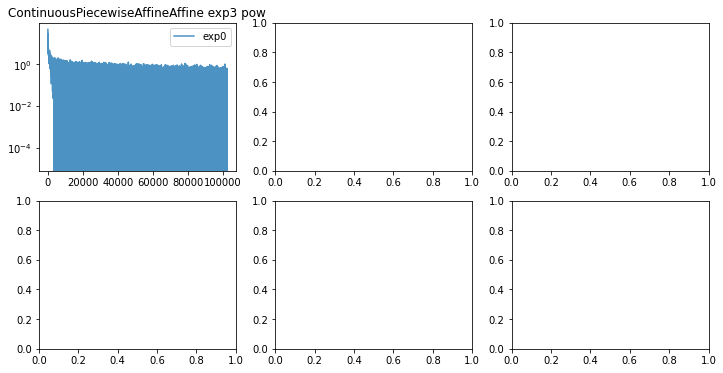

In [14]:
log_scale = True
from_iter = 50 * batch_size

fig, ax = plt.subplots(2, len(flows), figsize=(12,6))
for j, flowname in enumerate(flows.keys()):
    for i in range(num_exp):
        ax[0,j].plot(losses[flowname][i], label=f'exp{i}', alpha=0.8)
        ax[0,j].set_title(f'{flowname}')
        if log_scale:
            ax[0, j].set_yscale('log')
        ax[0, j].legend()

log_scale = True
for j, flowname in enumerate(flows.keys()):
    for i in range(num_exp):
        x = np.arange(len(losses[flowname][i]))
        ax[1,j].plot(x[from_iter:], losses[flowname][i][from_iter:], label=f'exp{i}', alpha=0.8)
        if log_scale:
            ax[1, j].set_yscale('log')
        ax[1, j].legend()
    
plt.tight_layout()

In [15]:
flow_lh_results = {
    'train': {n:[] for n in flows}, 
    'test': {n:[] for n in flows}, 
}
cur_res = 'train'

print('Results based on training data:' + '\n')

# Function for CI
def mean_confidence_interval(data, confidence=0.95):
    import scipy.stats
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, h
 

train_data = dataset.get_training_data()

for flow in best_flows:
    for i in range(num_exp):
        update_device(device, best_flows[flow][i], dataset)
        train_data = dataset.get_training_data()
        log_lik, mean = log_likelihood(train_data, best_flows[flow][i])
        flow_lh_results[cur_res][flow].append(mean[0])
        print("Mean loglikelihood for {}: {}".format(f'{flow} {i}', mean))

    
    m, h = mean_confidence_interval(flow_lh_results[cur_res][flow])
    print('-'*75)
    print(f'{flow} -- Mean LogLH Bootstrap: {m:7.4f} ± {h:7.4f}')
    print('-'*75)
    print()
    

print("Mean loglikelihood with actual distribution: {}".format(mean_target))

Results based on training data:



RuntimeError: CUDA out of memory. Tried to allocate 3.13 GiB (GPU 0; 10.76 GiB total capacity; 242.68 MiB already allocated; 1.72 GiB free; 276.00 MiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [18]:
print('Results based on test data' + '\n')
cur_res = 'test' 

test_data = dataset.get_test_data()

for flow in best_flows:
    for i in range(num_exp):
        update_device(device_cpu, best_flows[flow][i], dataset)
        
        
        test_data = dataset.get_test_data()
        log_lik, mean = log_likelihood(test_data, best_flows[flow][i])
        flow_lh_results[cur_res][flow].append(mean[0])
        print("Mean loglikelihood for {}: {}".format(f'{flow} {i}', mean))

        print()
    
    m, h = mean_confidence_interval(flow_lh_results[cur_res][flow])
    print('-'*75)
    print(f'{flow} -- Mean LogLH Bootstrap: {m:7.4f} ± {h:7.4f}')
    print('-'*75)
    print()
    


# for flow in best_flows:
#     log_lik, mean = log_likelihood(test_data, flow)
#     print("Mean loglikelihood for {}: {}".format(str(flow), mean))
#     print("Difference between target and {} mean loglikelihood: {}".format(str(flow), abs(mean-mean_target)))
    

# print("Mean loglikelihood with actual distribution: {}".format(mean_target))

Results based on test data

Mean loglikelihood for ContinuousPiecewiseAffineAffine exp3 pow 0: [0.15158509]



IndexError: list index out of range